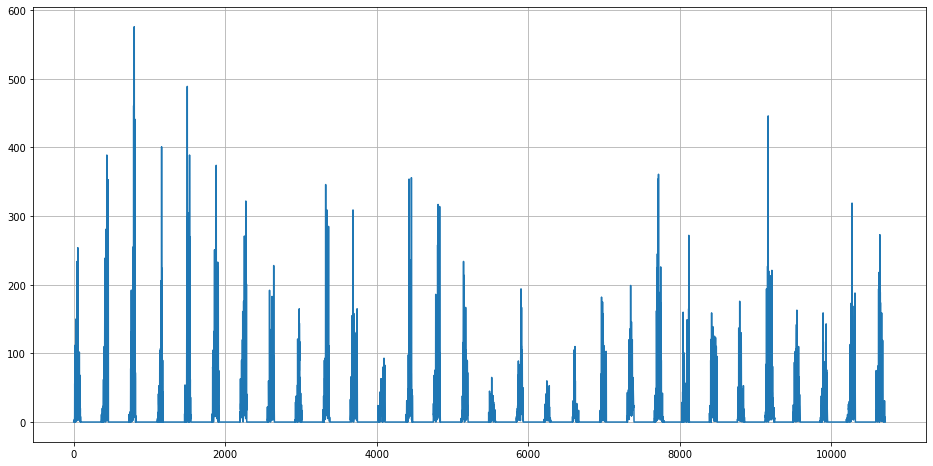

In [134]:
%matplotlib inline

import numpy as np
from scipy import signal
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


ds=pd.read_csv('/Users/demi/Desktop/pollen data/melbourne_grass_preprocessed.csv')
ds['grass_count'].plot(figsize=(16,8))
ds.set_index('Count Date',inplace=True,drop=False)
ds=ds.loc['2000-01-01':'2020-12-31']
# size of script
plt.tick_params(labelsize=10)
# generate grids
plt.grid()

In [28]:
ds

,Count Date,grass_count
Count Date,,
2000-01-01,2000-01-01,0.0
2000-01-02,2000-01-02,0.0
2000-01-03,2000-01-03,0.0
2000-01-04,2000-01-04,0.0
2000-01-05,2000-01-05,0.0
...,...,...
2021-01-27,2021-01-27,1.0
2021-01-28,2021-01-28,7.0
2021-01-29,2021-01-29,2.0


In [136]:
from fbprophet import Prophet

ds.columns = ['ds','y']
# split data
train_data=ds[0:6000]
test_data=ds[6000:]
# fit model
m = Prophet().fit(train_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -22.5228
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         13448   0.000532567       73.8601           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       13448.7   7.57856e-05        161.88   5.908e-07       0.001      235  LS failed, Hessian reset 
     199       13448.9   0.000666775       65.9616       2.509      0.6432      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       13448.9   0.000104004        97.718   1.457e-06       0.001      367  LS failed, Hessian reset 
     299       13449.1   4.47791e-07       59.0457      0.2628      0.2628      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       13449.1   2.79426e-07        65.373      0.1519      0.1519      494   
Optimization terminat

In [27]:
# forecast the following 1100 days
future = m.make_future_dataframe(periods=1100)
forecast = m.predict(future)

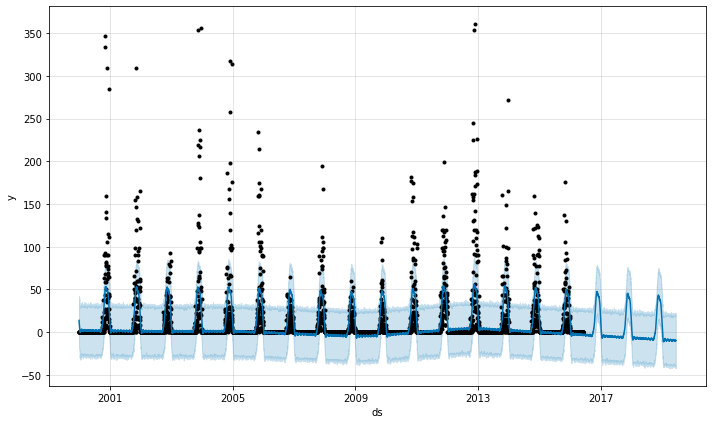

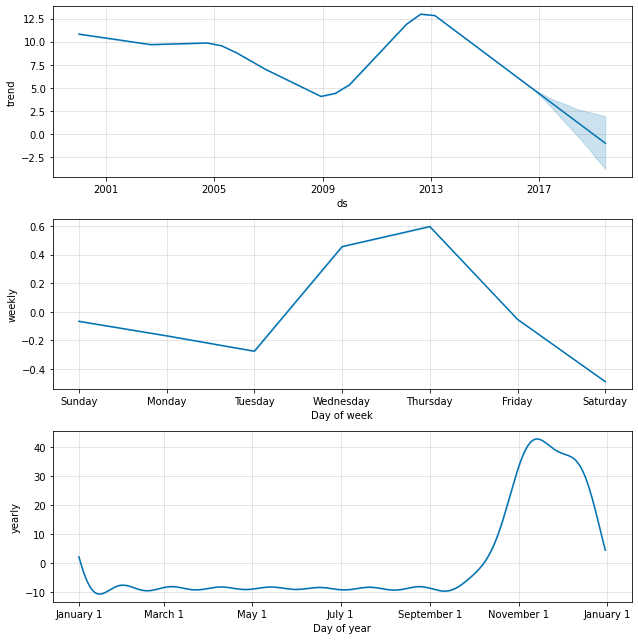

In [28]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -20.0145
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18350.6   0.000106886       368.473           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       18350.6   4.79678e-05       322.116   1.127e-07       0.001      196  LS failed, Hessian reset 
     130       18350.7   2.96441e-07       301.353      0.2954      0.2954      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


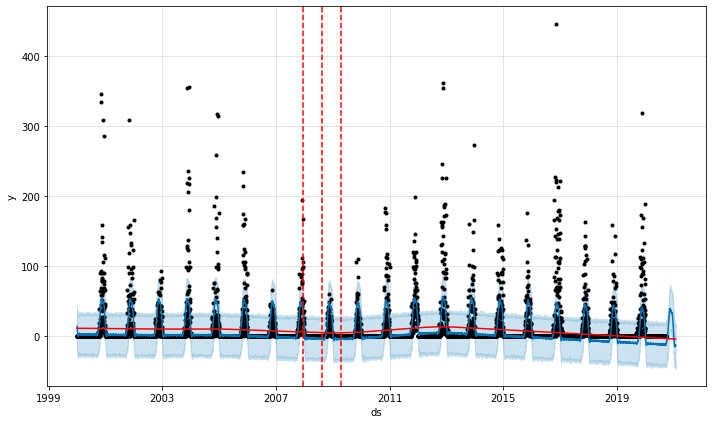

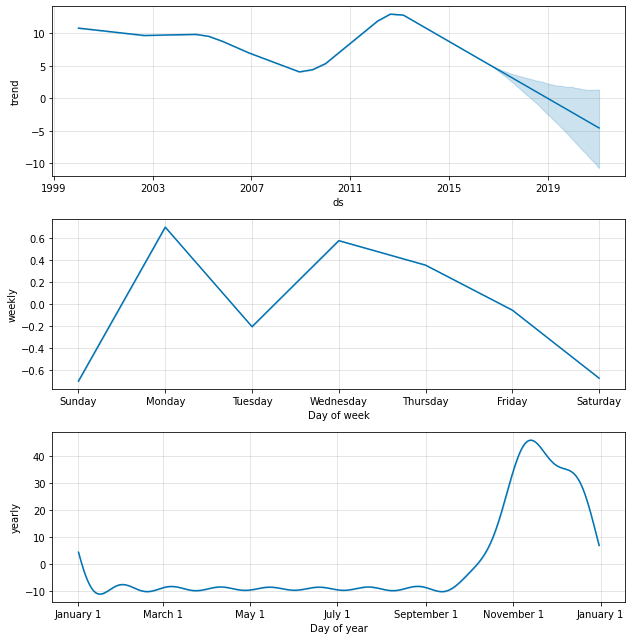

In [46]:
from fbprophet.plot import add_changepoints_to_plot

#调整数据趋势变化点为20个，changepoint_Preor_scale增加到0.01，使趋势更灵活
pro_change= Prophet(n_changepoints=25,yearly_seasonality=True, changepoint_prior_scale=0.01)
future = pro_change.fit(train_data).make_future_dataframe(periods=120)
forecast = m.predict(future)
fig1= pro_change.plot(forecast)
fig2 = pro_change.plot_components(forecast)
a = add_changepoints_to_plot(fig1.gca(), pro_change, forecast)




In [149]:
train_data=ds[0:7575]
test_data=ds[7575:]
# fit model
from fbprophet.plot import add_changepoints_to_plot

#调整数据趋势变化点为20个，changepoint_Preor_scale增加到0.01，使趋势更灵活
pro_change= Prophet(n_changepoints=15,yearly_seasonality=True,changepoint_prior_scale=0.001)
future = pro_change.fit(train_data).make_future_dataframe(periods=127)
forecast = pro_change.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -20.0145
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       18342.6   6.02062e-09       3470.35       0.201       0.201       80   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


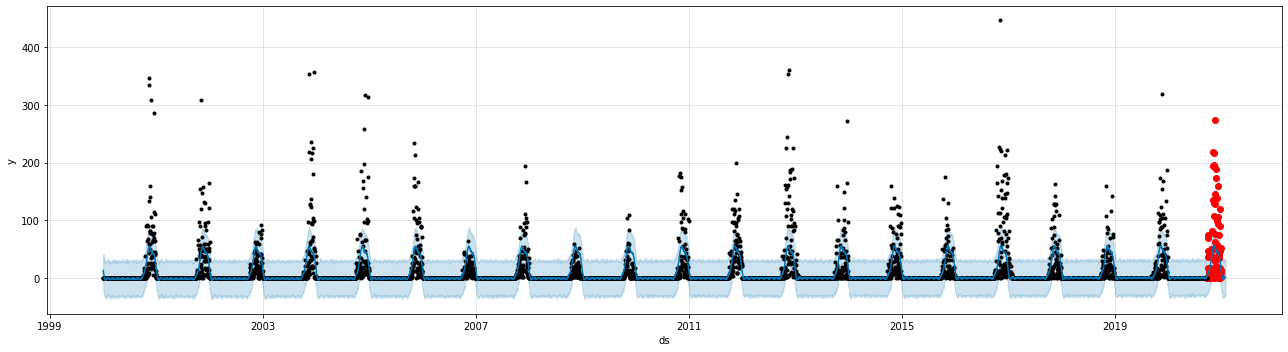

In [150]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(18)
fig = pro_change.plot(forecast, ax=ax)
ax.scatter(test_data['ds'], test_data['y'], color='r')

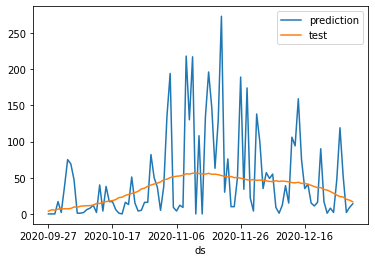

In [151]:
prophet_data_test2 = test_data.set_index('ds')

forecast1 = forecast[['ds','yhat']].set_index('ds')
# forecast['yhat'] = np.exp(forecast['yhat'])
df_all=pd.DataFrame()
df_all['y']=prophet_data_test2['y']
df_all['yhat']=forecast1['yhat']
# df_all = prophet_data_test2.join(forecast1)
# df_all = df_all.drop(columns = ['index']) # 如果上面没有resetindex这里就不用drop
# df_all=pd.concat([forecast1,prophet_data_test2],axis=1)
df_all.plot()

plt.legend(['prediction', 'test'])
plt.show()

In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
df_all=df_all[0:127]
y_true = df_all["y"]
y_pred = df_all["yhat"]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE Error in forecasts = {}'.format(round(rmse, 2)))

RMSE Error in forecasts = 56.84


In [141]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(pro_change, initial='7000 days', period='270 days', horizon = '120 days')
df_cv.head(120)



INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-09-02 00:00:00 and 2020-05-29 00:00:00


Initial log joint probability = -18.9245
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       17406.8   7.61572e-09        4141.3      0.1413      0.5434       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -20.0145
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       17992.7   1.74453e-08       3844.45      0.8738      0.8738       93   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-09-03,0.251131,-29.400425,30.874971,0.0,2019-09-02
1,2019-09-04,0.994163,-30.824795,30.925136,3.0,2019-09-02
2,2019-09-05,0.542998,-28.204576,27.976291,4.0,2019-09-02
3,2019-09-06,0.013095,-29.743692,32.884767,3.0,2019-09-02
4,2019-09-07,-0.706727,-28.871085,31.039067,2.0,2019-09-02
...,...,...,...,...,...,...
115,2019-12-27,25.319631,-7.036488,54.529069,11.0,2019-09-02
116,2019-12-28,22.700733,-8.122238,52.216301,188.0,2019-09-02
117,2019-12-29,20.838654,-8.660078,50.640305,52.0,2019-09-02
118,2019-12-30,19.890534,-12.216967,51.225581,81.0,2019-09-02


In [132]:
outputpath='/Users/demi/Desktop/prophet_forecast_cv.csv'
df_cv.to_csv(outputpath,sep=',',index=False,header=True)

In [142]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()



INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,12 days,3.768172,1.941178,1.509409,inf,1.0
1,13 days,5.774807,2.403083,1.818270,inf,1.0
2,14 days,5.648735,2.376707,1.776485,inf,1.0
3,15 days,5.222605,2.285302,1.677525,inf,1.0
4,16 days,5.091378,2.256408,1.671276,inf,1.0


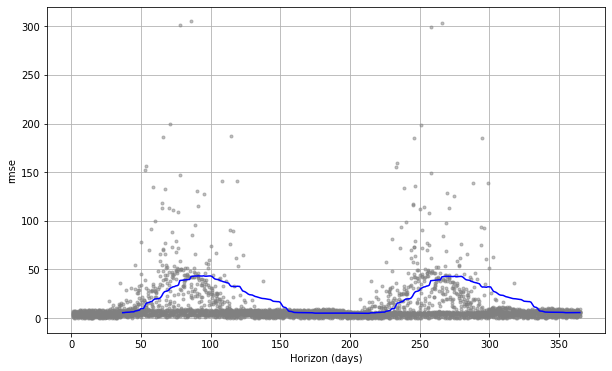

In [9]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')



In [12]:
# # SARIMAX model
import statsmodels.api as sm
import itertools
import warnings

warnings.filterwarnings("ignore") 
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]



In [84]:
# find the optimal model parameter
min_aic = 100000
best_param = None
best_param_season = None
i=0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ds['y'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if results.aic < min_aic:
                i +=1
                min_aic = results.aic
                best_param = param
                best_param_season = param_seasonal
            # print(i,param,param_seasonal,results.aic)
        except:
            continue



At iterate   25    f=  4.58671D+00    |proj g|=  2.22499D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   2.225D-05   4.587D+00
  F =   4.5867066996053678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63777D+00    |proj g|=  1.92640D-01

At iterate    5    f=  4.58916D+00    |proj g|=  4.41912D-03

At iterate   10    f=  4.58630D+00    |proj g|=  4.02039D-02

At iterate   15    f=  4.58562D+00    |proj g|=  9.45280D-05

At iterate   20    f=  4.58562D+00    |proj g|=  1.35031D-03

At iterate   25    f=  4.58562D+00    |proj g|=  3.43626D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     28      1     0     0   

In [38]:
print(i,best_param,best_param_season)

22 (1, 1, 1) (1, 1, 1, 12)


In [7]:
# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(ds['y'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75584D+00    |proj g|=  9.39259D-02


 This problem is unconstrained.



At iterate    5    f=  4.70203D+00    |proj g|=  1.12009D-01

At iterate   10    f=  4.68203D+00    |proj g|=  4.20619D-02

At iterate   15    f=  4.67979D+00    |proj g|=  1.38159D-01

At iterate   20    f=  4.60493D+00    |proj g|=  2.42200D-01

At iterate   25    f=  4.57682D+00    |proj g|=  2.69119D-01

At iterate   30    f=  4.57017D+00    |proj g|=  5.46846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     52      1     0     0   5.914D-05   4.570D+00
  F =   4.5701657642634705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>

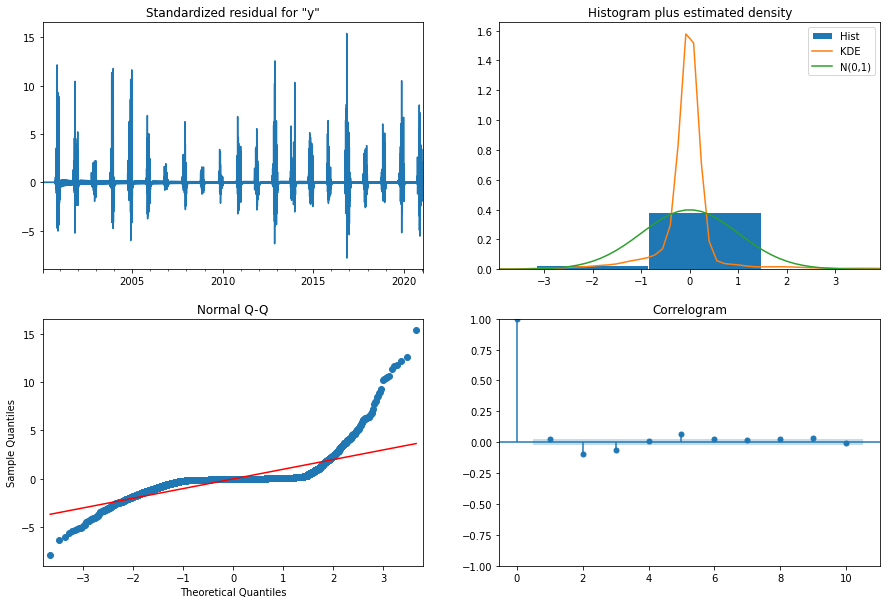

In [8]:
# 诊断
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [76]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=True)#预测值
pred_ci = pred.conf_int()#置信区间

In [77]:
pred_ci

,lower y,upper y
2020-01-01,0.735226,93.463928
2020-01-02,-0.166673,97.626331
2020-01-03,-0.356407,98.921932
2020-01-04,1.301591,101.555466
2020-01-05,0.308386,101.432392
...,...,...
2021-01-27,-92.388564,202.693038
2021-01-28,-91.206904,204.232472
2021-01-29,-90.873098,204.923621
2021-01-30,-92.564624,203.589012


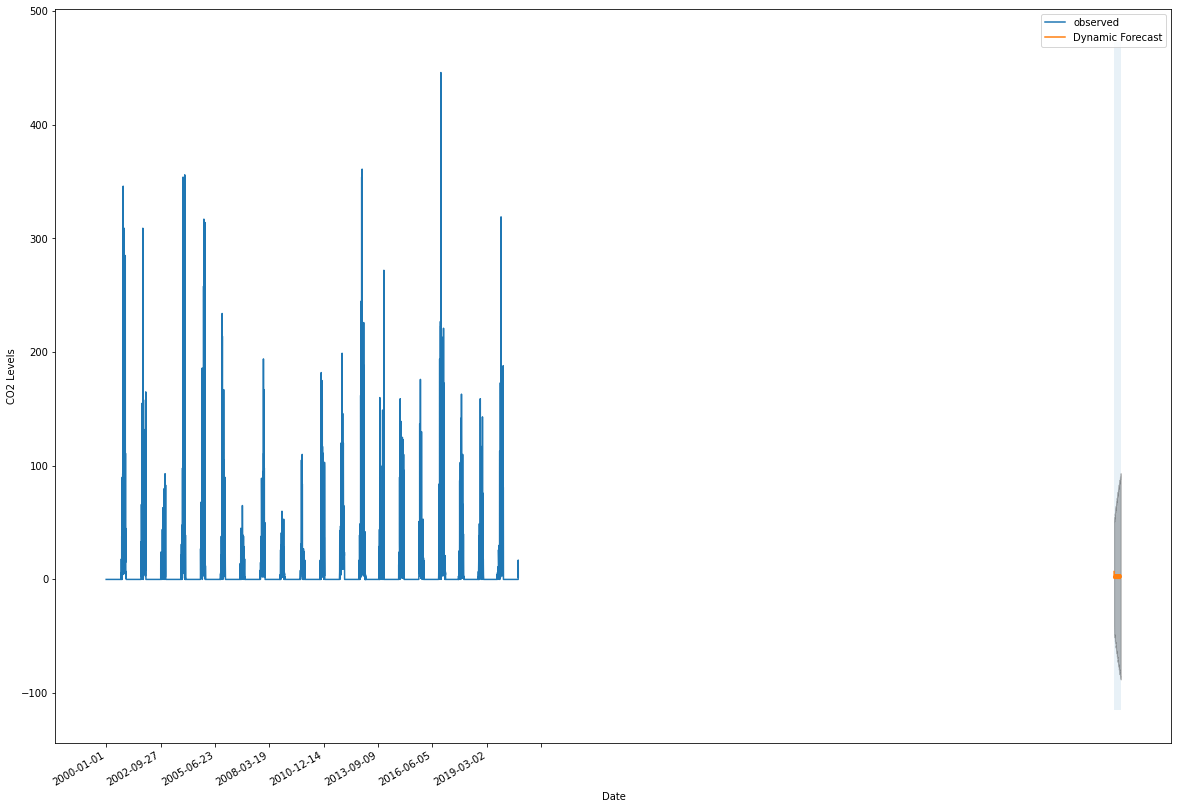

In [19]:
y=ds['y']
pred = results.get_prediction(start=pd.to_datetime('2020-10-01'), dynamic = True, full_results=True)
pred_ci = pred.conf_int()
ax = y['2000':'2020-10-01'].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
# pred.plot()
 
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
 
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-10-01'), y.index[-1],
                 alpha=.1, zorder=-1)
 
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
 
plt.legend()
plt.show()
#动态预测
# pred2 = results.get_prediction(start=pd.to_datetime('2020-10-01'), dynamic = True, full_results=True)
# pred_ci2 = pred2.conf_int()

# #预测图
# ax = y['2000-01-01':'2020-10-01'].plot(label='Original')
# pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=.7)

# ax.fill_between(pred_ci2.index,
#                 pred_ci2.iloc[:, 0],
#                 pred_ci2.iloc[:, 1], color='k', alpha=.2)

# ax.set_xlabel('Date')
# ax.set_ylabel('CO2')
# plt.legend()

# plt.show()






In [82]:
print(y)

Count Date
2000-01-01    0.0
2000-01-02    0.0
2000-01-03    0.0
2000-01-04    0.0
2000-01-05    0.0
             ... 
2021-01-27    1.0
2021-01-28    7.0
2021-01-29    2.0
2021-01-30    0.0
2021-01-31    0.0
Name: y, Length: 7702, dtype: float64


In [81]:
# Extract the predicted and true values of our time-series
y_forecasted =pred.predicted_mean
y_truth = y['2020-01-01':]
print(y_truth,y_forecasted)
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))



Count Date
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
             ... 
2021-01-27    1.0
2021-01-28    7.0
2021-01-29    2.0
2021-01-30    0.0
2021-01-31    0.0
Name: y, Length: 397, dtype: float64 2020-01-01    47.099577
2020-01-02    48.729829
2020-01-03    49.282762
2020-01-04    51.428528
2020-01-05    50.870389
                ...    
2021-01-27    55.152237
2021-01-28    56.512784
2021-01-29    57.025261
2021-01-30    55.512194
2021-01-31    55.102154
Freq: D, Name: predicted_mean, Length: 397, dtype: float64
nan
The Mean Squared Error of our forecasts is nan
